# Logistic Regression

It's like linear regression, but for binary classification. Like, what's the probability that someone will default on a loan. In this notebook We'll be looking at the famous Titanic dataset and trying to train a model to predict how likely someone would have been to have survived.

## Import

Begin by importing libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

## Data

The data exists already in this directory as a csv file. Actually, already as two files, with one named `titanic_train.csv` and the other `titanic_test.csv`, which seems unnecessary. Begin by merging these two into a pandas `DataFrame`.

In [2]:
top = pd.read_csv('titanic_train.csv')
bottom = pd.read_csv('titanic_test.csv')
passengers = pd.concat([top, bottom])
passengers.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


The `PassengerID` column is clearly useless, and `Ticket` is likely just noise as well, so drop them.

In [3]:
passengers.drop(['PassengerId', 'Ticket'], axis=1, inplace=True)

I don't care for how things are labeled here, so I'll take a moment to rename some things.

In [4]:
passengers.rename({'Pclass': 'Class',
                   'Parch': 'ParentsChildren',
                   'SibSp': 'SpousesSiblings'},
                   axis='columns',
                   inplace=True)
passengers.head(10)

,Age,Cabin,Embarked,Fare,Name,ParentsChildren,Class,Sex,SpousesSiblings,Survived
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,3,male,0,0.0
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,1,male,0,0.0
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,3,male,3,0.0
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,3,female,0,1.0
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,2,female,1,1.0


That looks nice. Now to a look at some broad observations.

In [5]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 10 columns):
Age                1046 non-null float64
Cabin              295 non-null object
Embarked           1307 non-null object
Fare               1308 non-null float64
Name               1309 non-null object
ParentsChildren    1309 non-null int64
Class              1309 non-null int64
Sex                1309 non-null object
SpousesSiblings    1309 non-null int64
Survived           891 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


In [6]:
passengers.describe()

,Age,Fare,ParentsChildren,Class,SpousesSiblings,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,3.000000,8.000000,1.000000


I happen to know that there is a lot of missing data. A plot can illuminate where they are.

NOTE: There might be a bug in this version of Seaborn or something else, because when I try to run this heatmap on boolean values, I get a mess of errors. After converting them to ints, however, it works fine.

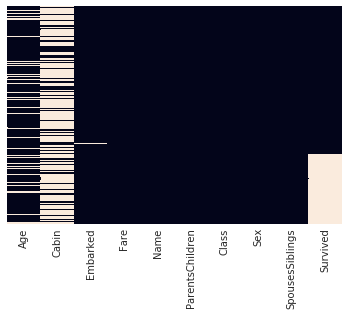

In [7]:
sns.heatmap(passengers.isnull().astype(int), yticklabels=False, cbar=False)

Cabin is clearly missing an enormous amount of entries. Better to just drop that column altogether. And passenger names is also not useful here.

In [8]:
passengers.drop(['Cabin', 'Name'], axis=1, inplace=True)

The `Age` column is missing some entries as well, but not so many that it would be smart to drop them feature entirely. Perhaps we can fill in the missing values with average ages. Even better, rather than using the average age of everyone, we could use the avergae age of each person's cohort. But what kind of cohort?

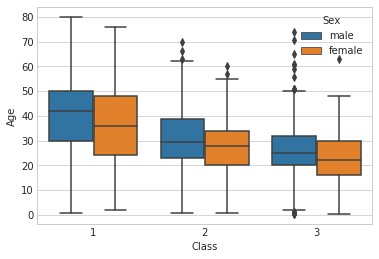

In [9]:
sns.boxplot(data=passengers, x='Class', y='Age', hue='Sex')

Each level of passenger class seems to have a noticably different mean age.

In [10]:
passengers.corr()

,Age,Fare,ParentsChildren,Class,SpousesSiblings,Survived
Age,1.000000,0.178740,-0.150917,-0.408106,-0.243699,-0.077221
Fare,0.178740,1.000000,0.221539,-0.558629,0.160238,0.257307
ParentsChildren,-0.150917,0.221539,1.000000,0.018322,0.373587,0.081629
Class,-0.408106,-0.558629,0.018322,1.000000,0.060832,-0.338481
SpousesSiblings,-0.243699,0.160238,0.373587,0.060832,1.000000,-0.035322
Survived,-0.077221,0.257307,0.081629,-0.338481,-0.035322,1.000000


OK, definitely class has the strongest association, so I'll go with that.

NOTE: This simple-looing solution took way too much time to reach.

In [11]:
mean_age = passengers.groupby('Class').mean()
mean_age_array = passengers['Class'].apply(lambda x: mean_age['Age'].loc[x])

display(mean_age)
display(mean_age_array.head(10))

,Age,Fare,ParentsChildren,SpousesSiblings,Survived
Class,,,,,
1,39.159930,87.508992,0.365325,0.436533,0.629630
2,29.506705,21.179196,0.368231,0.393502,0.472826
3,24.816367,13.302889,0.400564,0.568406,0.242363


0    24.816367
1    39.159930
2    24.816367
3    39.159930
4    24.816367
5    24.816367
6    39.159930
7    24.816367
8    24.816367
9    29.506705
Name: Class, dtype: float64

In [12]:
passengers['Age'].fillna(mean_age_array, inplace=True)
passengers.head(10)

,Age,Embarked,Fare,ParentsChildren,Class,Sex,SpousesSiblings,Survived
0,22.000000,S,7.2500,0,3,male,1,0.0
1,38.000000,C,71.2833,0,1,female,1,1.0
2,26.000000,S,7.9250,0,3,female,0,1.0
3,35.000000,S,53.1000,0,1,female,1,1.0
4,35.000000,S,8.0500,0,3,male,0,0.0
5,24.816367,Q,8.4583,0,3,male,0,0.0
6,54.000000,S,51.8625,0,1,male,0,0.0
7,2.000000,S,21.0750,1,3,male,3,0.0
8,27.000000,S,11.1333,2,3,female,0,1.0
9,14.000000,C,30.0708,0,2,female,1,1.0


Let's take a look at the heatmap one more time.

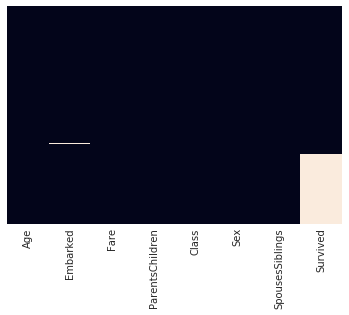

In [13]:
sns.heatmap(passengers.isnull().astype(int), yticklabels=False, cbar=False)

Looks much better. The cabin column is just hopeless, and that single row of missing embarked data is not recoverable, so drop them all. Also, drop the rows with unknown survival.

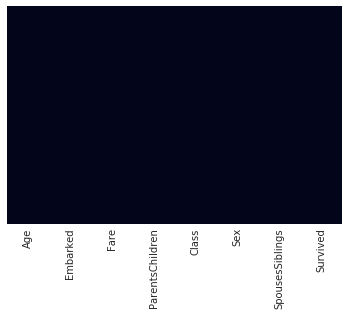

In [14]:
passengers.dropna(how='any', subset=['Embarked', 'Survived'], inplace=True)
sns.heatmap(passengers.isnull().astype(int), yticklabels=False, cbar=False)

Beautiful!

## Converting Categorical Features

In order to use categorical variables as predictors, they must be converted into binary dummy variables. When doing this sort of operation, you must only retain $k-1$ dummy variables in order to avoid multicolinearity.

In [15]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
Age                889 non-null float64
Embarked           889 non-null object
Fare               889 non-null float64
ParentsChildren    889 non-null int64
Class              889 non-null int64
Sex                889 non-null object
SpousesSiblings    889 non-null int64
Survived           889 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 62.5+ KB


In [16]:
sex = pd.get_dummies(passengers['Sex'], drop_first=True)
embarked = pd.get_dummies(passengers['Embarked'], drop_first=True)

# I like neatly-formatted labels.
sex.rename(columns={'female': 'Female', 'male': 'Male'}, inplace=True)
embarked.rename(columns={'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'}, inplace=True)

passengers.drop(['Sex', 'Embarked'], axis=1, inplace=True)

passengers = pd.concat([passengers, sex, embarked], axis=1)

passengers.head(10)

,Age,Fare,ParentsChildren,Class,SpousesSiblings,Survived,Male,Queenstown,Southampton
0,22.000000,7.2500,0,3,1,0.0,1,0,1
1,38.000000,71.2833,0,1,1,1.0,0,0,0
2,26.000000,7.9250,0,3,0,1.0,0,0,1
3,35.000000,53.1000,0,1,1,1.0,0,0,1
4,35.000000,8.0500,0,3,0,0.0,1,0,1
5,24.816367,8.4583,0,3,0,0.0,1,1,0
6,54.000000,51.8625,0,1,0,0.0,1,0,1
7,2.000000,21.0750,1,3,3,0.0,1,0,1
8,27.000000,11.1333,2,3,0,1.0,0,0,1
9,14.000000,30.0708,0,2,1,1.0,0,0,0


## Building a Logistic Regression Model

Hot damn the data munging part is done! Now to start doing some sophisticated analyses.

## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(passengers.drop('Survived', axis=1), # X
                                                    passengers['Survived'],      # y
                                                    test_size=0.3)

## Training the Model

In [19]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
pd.DataFrame(logmodel.coef_, columns=X_train.columns)

,Age,Fare,ParentsChildren,Class,SpousesSiblings,Male,Queenstown,Southampton
0,-0.033621,0.006567,-0.112867,-0.80416,-0.433337,-2.597574,0.080967,0.162483


Let's see how well the model works by putting its predictions up against the real thing.

In [20]:
predictions = logmodel.predict(X_test)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['Died', 'Survived']))

             precision    recall  f1-score   support

       Died       0.75      0.88      0.81       154
   Survived       0.79      0.60      0.68       113

avg / total       0.77      0.76      0.76       267



It's a pretty precise model, but not the least bit exciting. More useful information could possibly be extracted from passenger names (Mr, Mrs, etc.). Maybe even ticket numbers have something meaningful. None of that will be exxplored in this notebook however.